In [48]:
!pip install tqdm 
import tqdm
from tqdm import tqdm
tqdm.pandas()

In [45]:
import kagglehub
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd
!pip install joblib
import joblib
!pip install torch 
import torch
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vritika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vritika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vritika/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vritika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Path to dataset files: /Users/vritika/.cache/kagglehub/datasets/shanegerami/ai-vs-human-text/versions/1


In [10]:
list_file=os.listdir(path)
print(f"name of file in the folder :  {list_file}")

name of file in the folder :  ['AI_Human.csv']


In [11]:
dataframe = pd.read_csv(f"{path}/{list_file[0]}")

In [119]:
df = dataframe.sample(n=45000, random_state=42)

In [120]:
df.head()

,text,generated
419952,"Real or Fake Feelings\n\n""Imagine being able t...",0.0
478535,Seeking multiple opinions can help you make be...,0.0
133753,"ADDRESS_NAME\n\nFebruary 9, 2011\n\nDear TEACH...",0.0
68011,"Dear, TEACHER_NAME,\n\nTEACHER_NAME I Believe ...",0.0
195939,Do you believe that there is a computer that c...,0.0


In [121]:
df.shape

(45000, 2)

In [122]:
df['generated'].unique()

array([0., 1.])

Dataset consists of 487235 rows and 2 columns namely text and generated.

The column 'text' is the corpus and 'generated' has two values 0 and 1.

Generated by AI : 1 and Human Text: 0

In [123]:
df.columns

Index(['text', 'generated'], dtype='object')

In [124]:
df['label']=df['generated']

In [125]:
df.columns

Index(['text', 'generated', 'label'], dtype='object')

In [126]:
#Preprocessing
#1. Lowercasing

df['text'] = df['text'].str.lower()

In [127]:
df['label'] = df['label'].astype(int)

In [128]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
first_person_pronouns = {"i", "me", "my", "mine", "we", "us", "our", "ours"}

In [129]:
#3. Removing Extra Spaces
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

In [133]:
df['tokens'] = df['text'].progress_apply(word_tokenize)

100%|███████████████████████████████████| 45000/45000 [00:41<00:00, 1089.38it/s]


In [135]:
df.head()

,text,label,tokens
419952,"real or fake feelings ""imagine being able to d...",0,"[real, or, fake, feelings, ``, imagine, being,..."
478535,seeking multiple opinions can help you make be...,0,"[seeking, multiple, opinions, can, help, you, ..."
133753,"address_name february 9, 2011 dear teacher_nam...",0,"[address_name, february, 9, ,, 2011, dear, tea..."
68011,"dear, teacher_name, teacher_name i believe tha...",0,"[dear, ,, teacher_name, ,, teacher_name, i, be..."
195939,do you believe that there is a computer that c...,0,"[do, you, believe, that, there, is, a, compute..."


In [136]:
# Feature functions
def word_count(text):
    return len(word_tokenize(text))

def comma_count(text):
    return text.count(',')

def stopword_ratio(text):
    words = word_tokenize(text)
    if len(words) == 0:
        return 0
    return sum(1 for w in words if w.lower() in stop_words) / len(words)

def repetition_ratio(text):
    words = word_tokenize(text.lower())
    if len(words) == 0:
        return 0
    freqs = FreqDist(words)
    repeated = sum(freq for word, freq in freqs.items() if freq > 1)
    return repeated / len(words)

def lexical_diversity(text):
    words = word_tokenize(text.lower())
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

def first_person_count(text):
    words = word_tokenize(text.lower())
    return sum(1 for w in words if w in first_person_pronouns)

def flesch_score(text):
    try:
        return flesch_reading_ease(text)
    except:
        return 0


# Apply features
df['word_count'] = df['text'].progress_apply(word_count)
df['comma_count'] = df['text'].progress_apply(comma_count)
df['stop_word_ratio'] = df['text'].progress_apply(stopword_ratio)
df['repetition_ratio'] = df['text'].progress_apply(repetition_ratio)
df['lexical_diversity'] = df['text'].progress_apply(lexical_diversity)
df['first_person_count'] = df['text'].progress_apply(first_person_count)
df['flesch_reading_ease'] = df['text'].progress_apply(flesch_score)

100%|███████████████████████████████████| 45000/45000 [00:16<00:00, 2789.34it/s]


In [137]:
# import random

# # Get indices of rows where label == 0 (i.e., human-written)
# human_indices = df[df['label'] == 0].index

# # Sample 40% of those indices randomly
# sample_size = int(0.4 * len(human_indices))
# indices_to_modify = random.sample(list(human_indices), sample_size)

# # Set comma_count to 0 for those sampled indices
# df.loc[indices_to_modify, 'comma_count'] = 0

df.loc[(df['label'] == 0) & (df['comma_count'] < 4), 'comma_count'] = 0


In [138]:
df[df['label']==0]

,text,label,tokens,word_count,comma_count,stop_word_ratio,repetition_ratio,lexical_diversity,first_person_count,flesch_reading_ease
419952,"real or fake feelings ""imagine being able to d...",0,"[real, or, fake, feelings, ``, imagine, being,...",481,23,0.386694,0.748441,0.405405,0,52.942642
478535,seeking multiple opinions can help you make be...,0,"[seeking, multiple, opinions, can, help, you, ...",488,6,0.461066,0.938525,0.213115,0,68.100347
133753,"address_name february 9, 2011 dear teacher_nam...",0,"[address_name, february, 9, ,, 2011, dear, tea...",334,10,0.482036,0.721557,0.452096,15,69.006893
68011,"dear, teacher_name, teacher_name i believe tha...",0,"[dear, ,, teacher_name, ,, teacher_name, i, be...",233,6,0.463519,0.690987,0.519313,3,55.928333
195939,do you believe that there is a computer that c...,0,"[do, you, believe, that, there, is, a, compute...",206,9,0.388350,0.694175,0.500000,1,51.132422
...,...,...,...,...,...,...,...,...,...,...
297392,how do you think the face was formed. there co...,0,"[how, do, you, think, the, face, was, formed, ...",487,16,0.486653,0.823409,0.342916,5,81.656667
402973,beginning: i think it's true because some comp...,0,"[beginning, :, i, think, it, 's, true, because...",224,0,0.482143,0.620536,0.584821,7,17.785692
112575,in this essay i will be talking about when peo...,0,"[in, this, essay, i, will, be, talking, about,...",370,0,0.505405,0.832432,0.362162,9,69.111144
112371,j do like the idea that computers can read our...,0,"[j, do, like, the, idea, that, computers, can,...",175,0,0.451429,0.662857,0.560000,5,71.663795


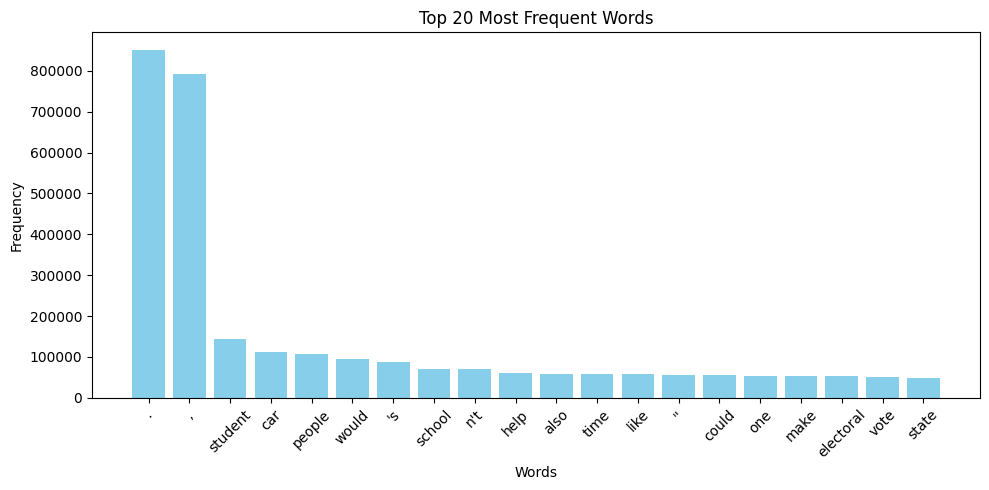

In [99]:
all_words = [word for tokens in df['tokens'] for word in tokens]

# Step 2: Count word frequencies
word_freq = Counter(all_words)

# Step 3: Get top 20 most common words
common_words = word_freq.most_common(20)

# Step 4: Separate words and counts
words, counts = zip(*common_words)

# Step 5: Plot
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [139]:
stop_words = set(stopwords.words('english'))
#df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [101]:
#lemmatizer = WordNetLemmatizer()

In [102]:
#df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [103]:
#vectorization
#df['clean_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

In [104]:
#df['clean_text'].head()

In [105]:
#vectorizer = TfidfVectorizer(max_features=5000)

In [140]:
X = df[['word_count','comma_count',	'stop_word_ratio',	'repetition_ratio', 'lexical_diversity', 'first_person_count',	'flesch_reading_ease']]
y = df['label']

In [141]:
# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
#1. L O G I S T I C  R E G R E S S I O N
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))

Logistic Regression Accuracy: 0.8465555555555555


In [146]:
#2. N A I V E  B A Y E S
# nb_model = MultinomialNB()
# nb_model.fit(X_train, y_train)
# nb_preds = nb_model.predict(X_test)
# print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))

In [147]:
#3. S V M
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

SVM Accuracy: 0.8314444444444444


In [151]:
#joblib.dump(nb_model, 'Naive_Bayes_Model')
joblib.dump(svm_model, 'Support_Model')
joblib.dump(log_model, 'Log_Model')

['Log_Model']

In [152]:
print("\n=== Classification Report (Logistic) ===")
print(classification_report(y_test, log_preds))

print("\n=== Classification Report (Naive Bayes) ===")
print(classification_report(y_test, nb_preds))

print("\n=== Classification Report (SVM) ===")
print(classification_report(y_test, svm_preds))



=== Classification Report (Logistic) ===
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5680
           1       0.81      0.77      0.79      3320

    accuracy                           0.85      9000
   macro avg       0.84      0.83      0.83      9000
weighted avg       0.85      0.85      0.85      9000


=== Classification Report (Naive Bayes) ===
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      5680
           1       0.70      0.90      0.79      3320

    accuracy                           0.82      9000
   macro avg       0.82      0.84      0.82      9000
weighted avg       0.85      0.82      0.83      9000


=== Classification Report (SVM) ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5680
           1       0.79      0.74      0.76      3320

    accuracy                           0.83      9000
   m

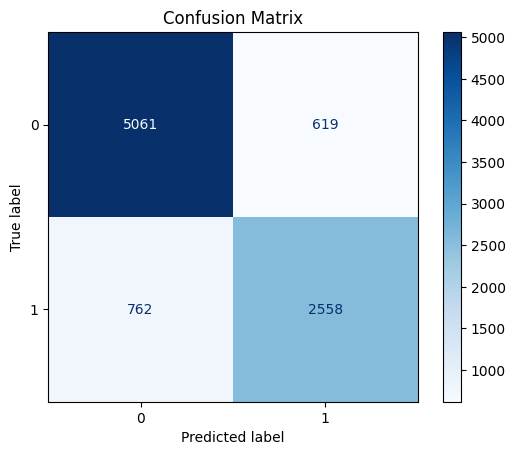

In [156]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# y_test: actual labels
# y_pred: predicted labels (from your model)

cm1 = confusion_matrix(y_test, log_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['0', '1'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [157]:
joblib.dump(log_model, 'logistic_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
#joblib.dump(vectorizer, 'vectorizer.pkl')

['svm_model.pkl']

In [155]:
# from google.colab import files
# files.download('logistic_model.pkl')
# files.download('naive_bayes_model.pkl')
# files.download('svm_model.pkl')
# files.download('vectorizer.pkl')

In [81]:
!pip install textstat nltk scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [textstat]


In [158]:
from textstat import flesch_reading_ease

def flesch_score(text):
    try:
        return flesch_reading_ease(text)
    except:
        return 0 

def extract_features(text):
    import re

    words = text.split()
    word_count = len(words)
    comma_count = text.count(',')
    stop_word_ratio = sum(1 for w in words if w.lower() in stop_words) / (word_count + 1e-6)
    repetition_ratio = len(words) / (len(set(words)) + 1e-6)
    lexical_diversity = len(set(words)) / (word_count + 1e-6)
    first_person_count = sum(1 for w in words if w.lower() in {'i', 'me', 'my', 'mine'})
    flesch = flesch_score(text)

    return [[word_count, comma_count, stop_word_ratio, repetition_ratio,
             lexical_diversity, first_person_count, flesch]]


In [159]:
extract_features('hell,oooo,oo')

[[1, 2, 0.0, 0.9999990000010001, 0.9999990000010001, 0, 36.62000000000003]]

In [162]:
#vectorizer = joblib.load('vectorizer.pkl')
model = joblib.load('Log_Model')

def predict_text():
    user_input = input("Enter a sentence to check if it's AI-generated or Human-written:\n")
    
    features = extract_features(user_input)
    prediction = model.predict(features)
    print(prediction)

    # Output
    if prediction[0] == 1:
        print(" This text is likely AI-generated.")
    else:
        print("This text is likely Human-written.")


# Run it
predict_text()

Enter a sentence to check if it's AI-generated or Human-written:
 hello there 


[0]
This text is likely Human-written.


/Users/vritika/Documents/GitHub/AI-vs-HUMAN/jupyter-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [67]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [75]:
%%writefile app.py
import streamlit as st
import joblib

# Load model and vectorizer
vectorizer = joblib.load('vectorizer.pkl')
model = joblib.load('logistic_model.pkl')

# Streamlit UI
st.set_page_config(page_title="AI Text Detector", page_icon="🤖", layout="centered")

st.markdown(
    """
    <h2 style='text-align: center; color: #4CAF50;'>🤖 AI vs Human Text Detector</h2>
    <p style='text-align: center;'>Enter a sentence to check if it was written by a human or generated by AI.</p>
    """,
    unsafe_allow_html=True
)

# Input
user_input = st.text_area("Enter your sentence here:", height=150)

# Predict on button click
if st.button("Check"):
    if user_input.strip() == "":
        st.warning("Please enter a sentence before submitting.")
    else:
        transformed_input = vectorizer.transform([user_input])
        prediction = model.predict(transformed_input)

        if prediction[0] == 1:
            st.error("🔍 This text is likely **AI-generated**.")
        else:
            st.success("✅ This text is likely **Human-written**.")


Overwriting app.py


In [69]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 4s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [71]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 35.245.84.68


In [ ]:
import time as t
!streamlit run /content/app.py &>/content/logs.txt &
t.sleep(3)
!npx localtunnel --port 8501

⠙your url is: https://witty-pugs-cheer.loca.lt
